In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Generate toy dataset
class SimpleSequenceDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=10):
        self.num_samples = num_samples
        self.seq_length = seq_length
        
        # Generate random sequences of integers (0-9)
        self.input_sequences = torch.randint(0, 10, (num_samples, seq_length))
        # Target is input reversed
        self.target_sequences = torch.flip(self.input_sequences, dims=[1])
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.input_sequences[idx], self.target_sequences[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=100):
        super().__init__()
        
        position = torch.arange(max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)
        return torch.matmul(attention_weights, V)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        # Linear transformations and reshape
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        x = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads and apply final linear transformation
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(x)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention and residual connection
        attention_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attention_output))
        
        # Feed-forward and residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length=100, dropout=0.1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask)
            
        return self.output_layer(x)



Epoch 1/100
Training Loss: 2.3373
Training Accuracy: 0.1224
Test Accuracy: 0.1585
--------------------------------------------------
Epoch 2/100
Training Loss: 2.2360
Training Accuracy: 0.1715
Test Accuracy: 0.2195
--------------------------------------------------
Epoch 3/100
Training Loss: 2.1401
Training Accuracy: 0.2157
Test Accuracy: 0.2595
--------------------------------------------------
Epoch 4/100
Training Loss: 2.0465
Training Accuracy: 0.2516
Test Accuracy: 0.2665
--------------------------------------------------
Epoch 5/100
Training Loss: 1.9656
Training Accuracy: 0.2729
Test Accuracy: 0.2930
--------------------------------------------------
Epoch 6/100
Training Loss: 1.9013
Training Accuracy: 0.2891
Test Accuracy: 0.3090
--------------------------------------------------
Epoch 7/100
Training Loss: 1.7975
Training Accuracy: 0.3305
Test Accuracy: 0.3665
--------------------------------------------------
Epoch 8/100
Training Loss: 1.6516
Training Accuracy: 0.3781
Test Accu

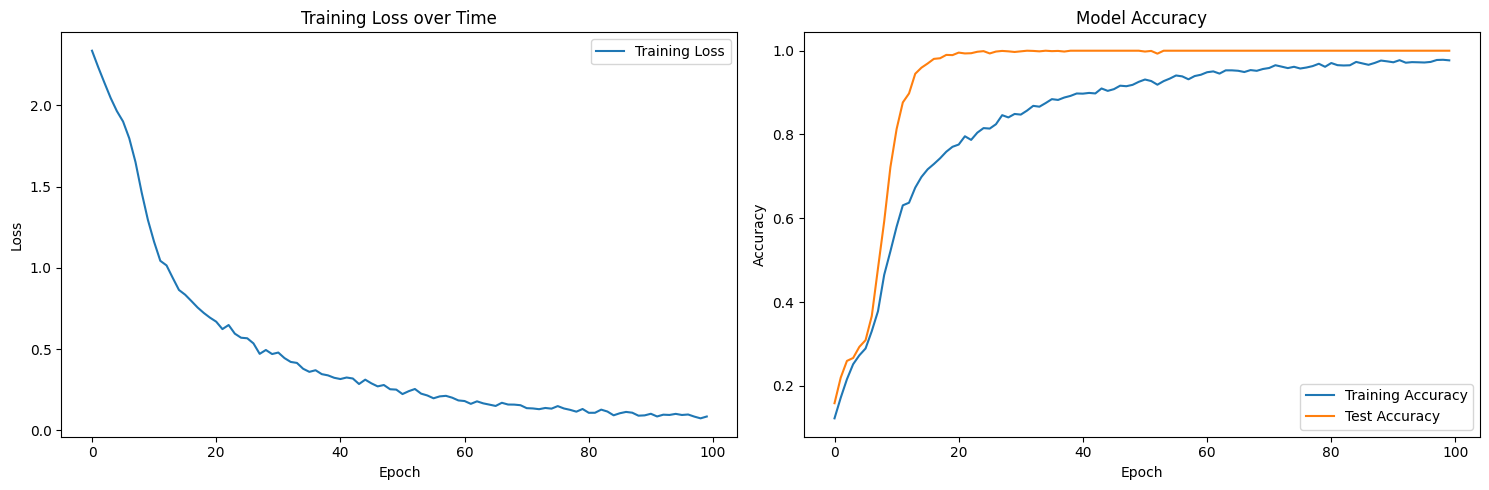

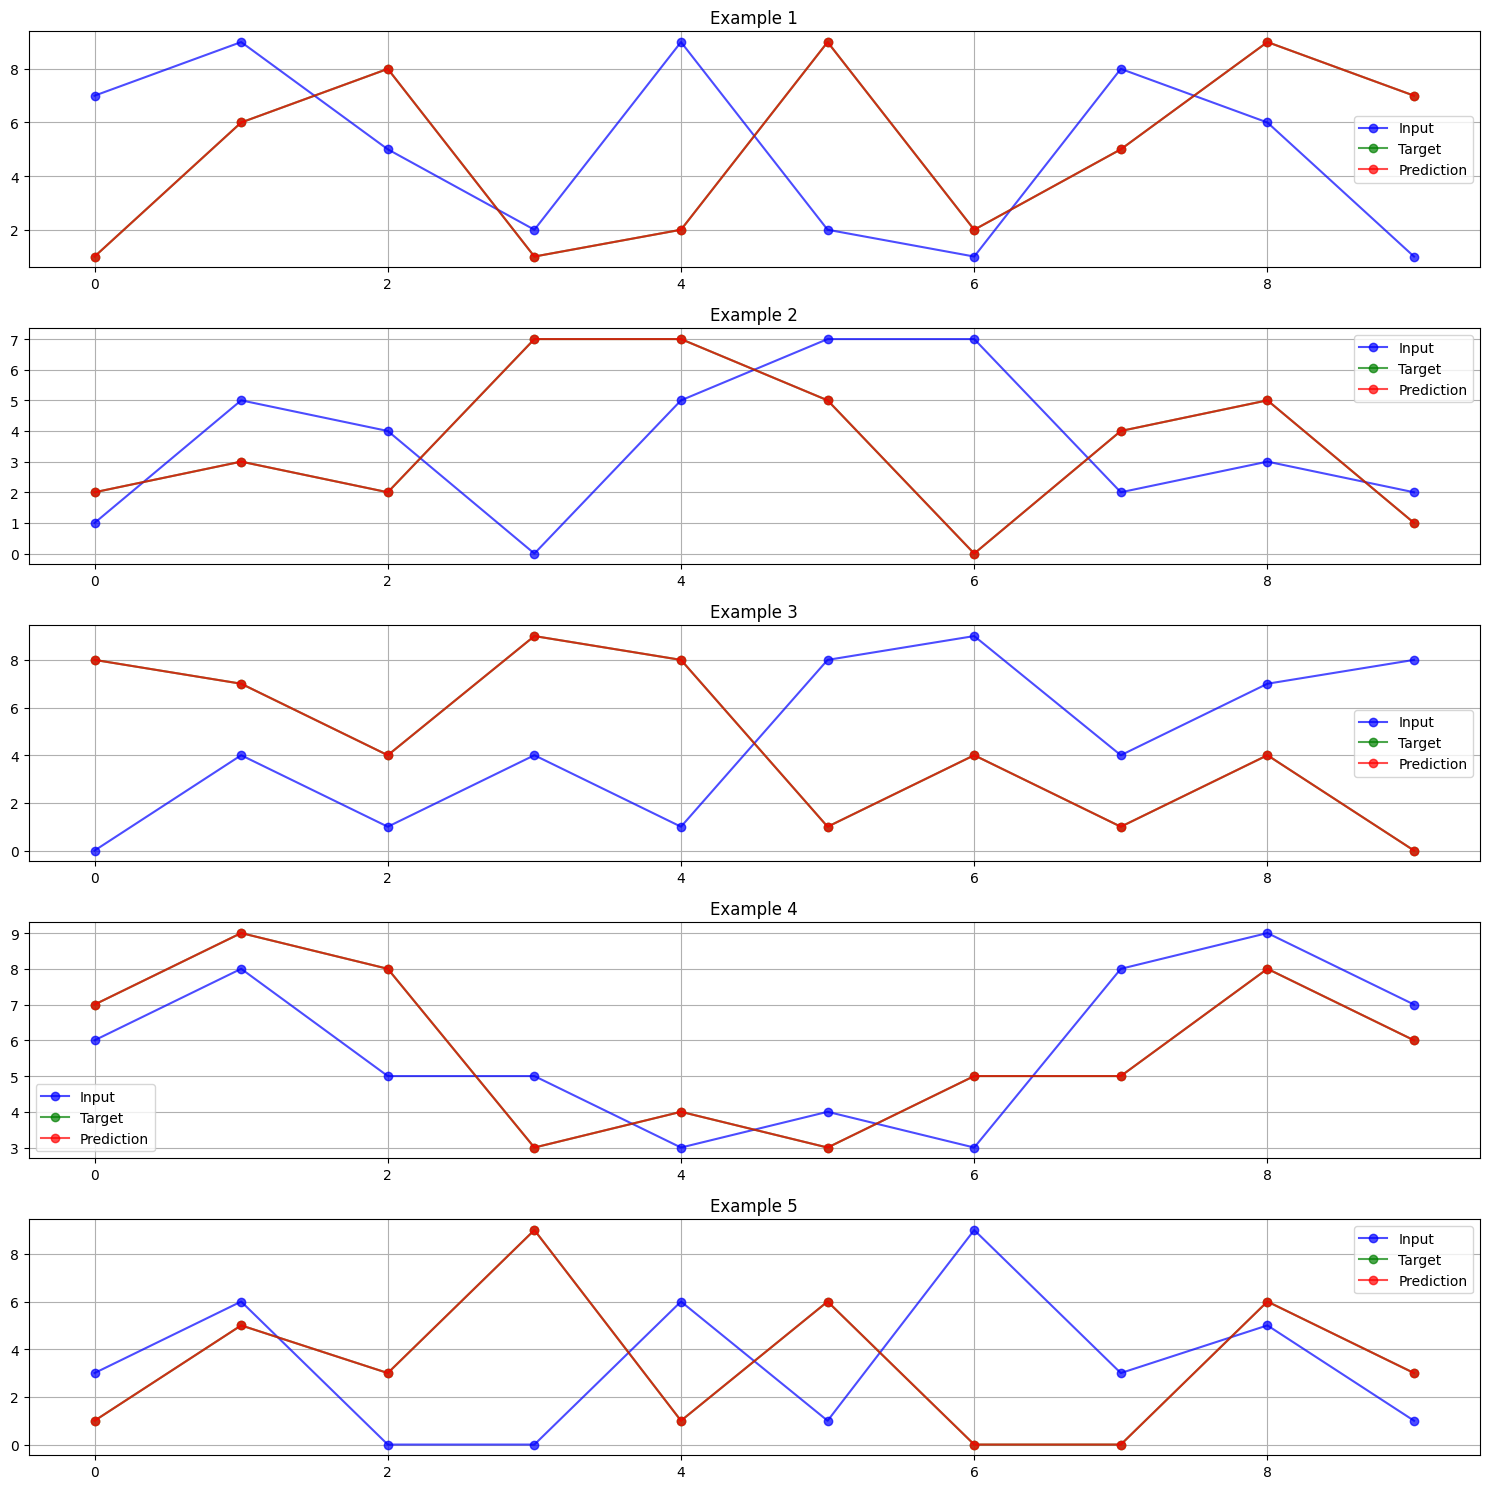

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split

class TransformerVisualizer:
    def __init__(self, model, dataset, batch_size=32):
        self.model = model
        self.batch_size = batch_size
        
        # Split dataset into train and test
        test_size = int(0.2 * len(dataset))
        train_size = len(dataset) - test_size
        self.train_dataset, self.test_dataset = random_split(dataset, [train_size, test_size])
        
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size)
        
        # Metrics storage
        self.train_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        
    def train_epoch(self, criterion, optimizer):
        self.model.train()
        total_loss = 0
        predictions = []
        targets = []
        
        for input_seq, target_seq in self.train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            output = self.model(input_seq)
            
            # Reshape output and target for loss calculation
            batch_size, seq_len, vocab_size = output.shape
            output = output.view(-1, vocab_size)
            target = target_seq.view(-1)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Store predictions and targets for accuracy calculation
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
        
        avg_loss = total_loss / len(self.train_loader)
        accuracy = accuracy_score(targets, predictions)
        
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
        
        return avg_loss, accuracy
    
    def evaluate(self):
        self.model.eval()
        predictions = []
        targets = []
        
        with torch.no_grad():
            for input_seq, target_seq in self.test_loader:
                output = self.model(input_seq)
                
                # Get predictions
                pred = output.argmax(dim=2)
                predictions.extend(pred.cpu().numpy())
                targets.extend(target_seq.cpu().numpy())
        
        accuracy = accuracy_score(np.array(targets).flatten(), 
                                np.array(predictions).flatten())
        self.test_accuracies.append(accuracy)
        
        return accuracy
    
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot training loss
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.set_title('Training Loss over Time')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.test_accuracies, label='Test Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    def visualize_predictions(self, num_examples=5):
        self.model.eval()
        
        # Get random test samples
        test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=True)
        examples = []
        
        with torch.no_grad():
            for input_seq, target_seq in test_loader:
                if len(examples) >= num_examples:
                    break
                    
                output = self.model(input_seq)
                pred = output.argmax(dim=2)
                
                examples.append({
                    'input': input_seq.squeeze().cpu().numpy(),
                    'target': target_seq.squeeze().cpu().numpy(),
                    'prediction': pred.squeeze().cpu().numpy()
                })
        
        # Plot the sequences
        fig, axes = plt.subplots(num_examples, 1, figsize=(15, 3*num_examples))
        if num_examples == 1:
            axes = [axes]
        
        for i, example in enumerate(examples):
            ax = axes[i]
            ax.plot(example['input'], 'b-o', label='Input', alpha=0.7)
            ax.plot(example['target'], 'g-o', label='Target', alpha=0.7)
            ax.plot(example['prediction'], 'r-o', label='Prediction', alpha=0.7)
            ax.set_title(f'Example {i+1}')
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()

def train_and_visualize():
    # Initialize model and dataset (using previous implementation)
    vocab_size = 10
    d_model = 32
    num_heads = 4
    num_layers = 2
    d_ff = 128
    num_epochs = 100
    learning_rate = 0.001
    
    dataset = SimpleSequenceDataset()
    model = SimpleTransformer(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff
    )
    
    # Initialize visualizer
    visualizer = TransformerVisualizer(model, dataset)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop with visualization
    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, train_acc = visualizer.train_epoch(criterion, optimizer)
        
        # Evaluate on test set
        test_acc = visualizer.evaluate()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print("-" * 50)
    
    # Plot final metrics
    visualizer.plot_metrics()
    
    # Visualize some predictions
    visualizer.visualize_predictions()

if __name__ == "__main__":
    train_and_visualize()